In [1]:
import torch

In [2]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.__version__

'1.5.1+cu101'

In [5]:
#변수를 선언한다
x = torch.ones(2,2,requires_grad= True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


In [6]:
#tensor x에 대한 연산
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


In [7]:
#tensor x에 대한 연산 수행 후, grad_fn을 가진다
print(y.grad_fn)

In [8]:
#y에 대한 추가 연산
z = y * y * 3
out = z.mean()
print(z, out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)


In [9]:
print(x.grad)
#사용자가 직접 생성한 변수이기 때문에 x의 grad_fn은 None이다.

None


In [10]:
#역전파 실시
out.backward()

In [11]:
# d(out) / dx를 계산 - out을 x에 대해서 미분
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()
    #convolution layer
    #1개의 입력 채널, 6개의 출력 채널, 5x5 크기의 필터
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.conv2 = nn.Conv2d(6, 16, 5)
    
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    # (2,2) 크기의 윈도우 Max Pooling
    x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
    # 단일 숫자 입력시 정사각형 --> (2,2)=(2)
    x = F.max_pool2d(F.relu(self.conv2(x)),2)
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
  
  #feature size 에 data 변경
  def num_flat_features(self,x):
    size = x.size()[1:]
    num_features = 1
    for s in size:
      num_features *= s
    return num_features

net = Net()
print(net)


Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [13]:
# input -> conv2d -> relu -> maxpool2d -> relu -> maxpool2d ->
#     view -> linear(fc1)-> relu ->linear(fc2) -> relu ->linear(fc3)

params = list(net.parameters())
print(len(params))
print(params[0].size()) #conv1 의 weight
print(params[1].size()) #maxpool2d의 size


10
torch.Size([6, 1, 5, 5])
torch.Size([6])


In [15]:
input = torch.randn(1,1,32,32) #임의의 input 값
output = net(input) #구성해둔 network model에 input data 입력
target = torch.randn(10) #예제 목표치 설정
target = target.view(1,-1) #출력 형태를 맞추기 위한 resizing
criterion = nn.MSELoss() #Mean squared error 의 손실 함수 이용
loss = criterion(output, target)
print(loss)

tensor(0.9666, grad_fn=<MseLossBackward>)


In [17]:
import torch.optim as optim

#Optimizer 생성
optimizer = optim.SGD(net.parameters(),lr = 0.01)

#학습하는 동안 수행해야 하는 작업
optimizer.zero_grad() #기울기 버퍼를 0으로 초기화
output = net(input)
loss = criterion(output,target)
loss.backward()
optimizer.step() #Optimizer 업데이트 수행


In [19]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #이미지 정규화

#cifar10의 학습 데이터
trainset = torchvision.datasets.CIFAR10(root='./data',train = True,
                                        download = True, transform = transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle = True, num_workers=2)

#cifar10의 테스트 데이터
testset = torchvision.datasets.CIFAR10(root='./data',train = False, 
                                       download = True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 4,
                                         shuffle = False, num_workers = 2)

#cifar10 이미지의 데이터 클래스
classes = ('plane', 'car','bird','cat','deer','dog',
           'frog','horse','ship','truck')

    

Files already downloaded and verified
Files already downloaded and verified


  cat truck  deer  frog


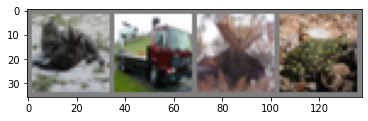

In [23]:
import matplotlib.pyplot as plt
import numpy as np

#이미지 호출
def imshow(img):
  img = img /2 + 0.5 #비정규화
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))

#트레이닝 데이터 중 일부를 호출
dataiter = iter(trainloader)
images, labels = dataiter.next()

#이미지 출력
imshow(torchvision.utils.make_grid(images))

#이미지 label 출력
print(' '.join('%5s' %classes[labels[j]] for j in range(4)))

In [24]:
import torch.nn as nn
import torch.nn.functional as F

#2개의 conv layer, 1개의 pooling layer, 3개의 fc layer로 구성
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6,16,5)
    self.fc1 = nn.Linear(16*5*5,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)

  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [26]:
import torch.optim as optim

#SGD Optimizer와 CrossEntropy loss function 을 이용하여 최적화
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr = 0.0001, momentum = 0.9)


In [29]:
for epoch in range(2):
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data

    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 2000 == 1999:
      print('[%d, %5d] loss : %.3f' %
            (epoch + 1, i+1, running_loss / 2000))
      running_loss = 0.0

[1,  2000] loss : 2.303
[1,  4000] loss : 2.301
[1,  6000] loss : 2.298
[1,  8000] loss : 2.293
[1, 10000] loss : 2.277
[1, 12000] loss : 2.223
[2,  2000] loss : 2.093
[2,  4000] loss : 2.003
[2,  6000] loss : 1.934
[2,  8000] loss : 1.892
[2, 10000] loss : 1.849
[2, 12000] loss : 1.817
